In [1]:
import gsw, time, datetime, sys, os, glob, xgcm, matplotlib, xarray as xr, numpy as np, dask.array as da, pandas as pd, cartopy.crs as ccrs
import matplotlib.patches as patches, cmocean
from scipy import signal, fft
import xrft
from xhistogram.xarray import histogram
import cartopy.mpl.ticker as cticker, string
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import LogNorm, TwoSlopeNorm
import matplotlib.pyplot as plt, matplotlib.colors as colors, matplotlib.dates as mdates

In [2]:
def plotting_stat_data(x, y, z, xb, yb):
    x, y, z = np.ravel(x), np.ravel(y), np.ravel(z)

    sum_w, _, _ = np.histogram2d(x, y, bins=(xb, yb), weights=z)

    count, _, _ = np.histogram2d(x, y, bins=(xb, yb))

    count_norm = count / np.max(count)
    count_norm[count_norm < 1e-3] = np.nan  # filtra valores poco frecuentes

    with np.errstate(invalid='ignore', divide='ignore'):
        avg = sum_w / count

    masked_avg = np.where(~np.isnan(count_norm), avg, np.nan)

    return count_norm, masked_avg

In [3]:
xb = np.linspace(-2,2,100)
yb = np.linspace(-2,2,100) 
xx, yy = 0.5*(xb[:-1]+xb[1:]), 0.5*(yb[:-1]+yb[1:])

In [4]:
ds = xr.open_mfdataset("/home/fcampos/Desktop/campos_et_al/data/outputs_dynamical_filtering/gradients_tot_coas.nc",
                      parallel=True,
                      ).squeeze().transpose("longitude", "latitude", "time")
dc = xr.open_mfdataset("/home/fcampos/Desktop/campos_et_al/data/outputs_dynamical_filtering/gradients_tot_ocean_forced.nc",
                      parallel=True,
                      ).squeeze().transpose("longitude", "latitude", "time")

/home/fcampos/miniconda3/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'argo' loading failed:
cannot import name 'resolve_auth_type' from 'botocore.auth' (/home/fcampos/miniconda3/lib/python3.11/site-packages/botocore/auth.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
jpdf_coas, jpdf3d_coas = plotting_stat_data(ds.Ro.values, ds.nstr.values, ds.divn.values, xb, yb)
jpdf_llc, jpdf3d_llc = plotting_stat_data(dc.Ro.values, dc.nstr.values, dc.divn.values, xb, yb)

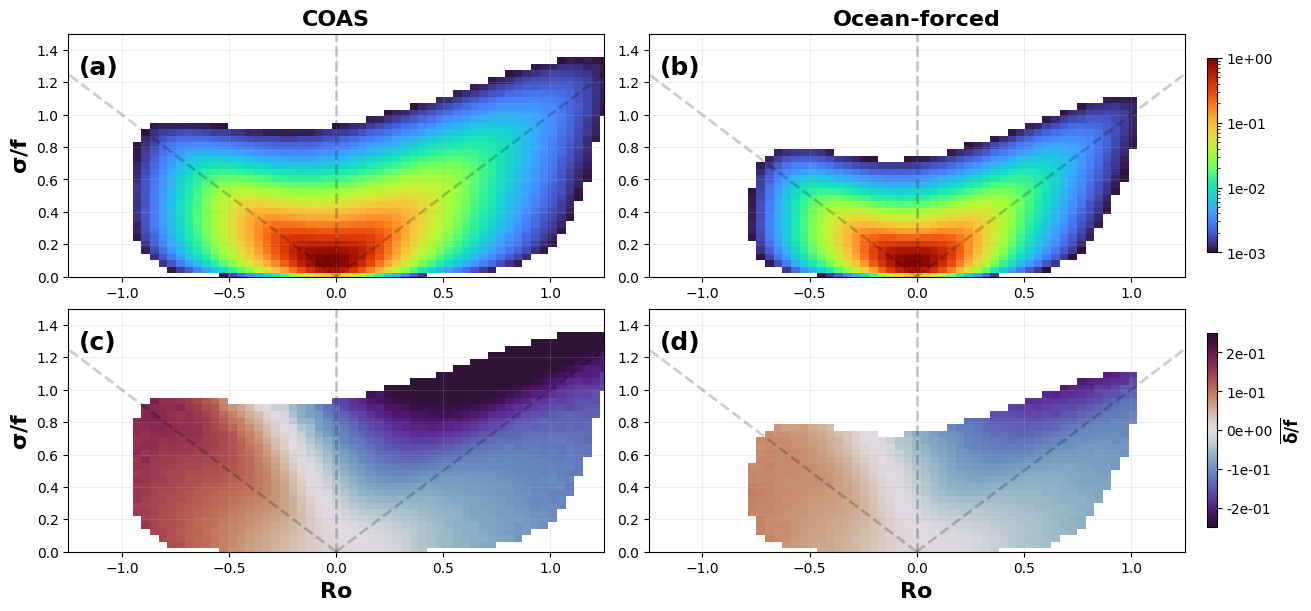

In [6]:
alphabet, num = string.ascii_lowercase, 0

fig2, ax = plt.subplots(2,2, figsize=(13,6),constrained_layout=True)

cmap = plt.get_cmap('twilight_shifted', )    # 11 discrete colors

az = ax[1,0].pcolormesh(xx,yy, jpdf3d_coas.T, vmin=-0.25, vmax=0.25, cmap = cmap, rasterized=True,)
#ax[1,0].set_title("COAS", fontweight="bold", size=16)
az = ax[1,1].pcolormesh(xx,yy, jpdf3d_llc.T, vmin=-0.25, vmax=0.25, cmap = cmap, rasterized=True,)
#ax[1,1].set_title("Ocean-forced", fontweight="bold", size=16)

cmap = plt.get_cmap('turbo', )    # 11 discrete colors

az0 = ax[0,0].pcolormesh(xx,yy, jpdf_coas.T,cmap = cmap, norm=LogNorm(vmin=1e-3, vmax=1e0), rasterized=True,)
ax[0,0].set_title("COAS", fontweight="bold", size=16)
az0 = ax[0,1].pcolormesh(xx,yy, jpdf_llc.T,cmap = cmap, norm=LogNorm(vmin=1e-3, vmax=1e0), rasterized=True,)
ax[0,1].set_title("Ocean-forced", fontweight="bold", size=16)

ax[1,0].set_ylabel("$\mathbf{\sigma}$/f", fontweight="bold", size=16)
ax[0,0].set_ylabel("$\mathbf{\sigma}$/f", fontweight="bold", size=16)

for i in range(2):
    ax[0,i].text(-1.2,1.25, "("+str(alphabet[i])+")", fontweight="bold", color="black", fontsize=18)
    ax[1,i].text(-1.2,1.25, "("+str(alphabet[i+2])+")", fontweight="bold", color="black", fontsize=18)
    ax[1,i].set_xlabel("Ro", fontweight="bold", size=16)
for i in range(2):
    for j in range(2):
        ax[j,i].plot([0,0],[-2,2], '--', linewidth=2, color="black", alpha = 0.2)
        ax[j,i].plot([0,2],[0,2], '--', linewidth=2, color="black", alpha = 0.2)
        ax[j,i].plot([0,-2],[0,2], '--', linewidth=2, color="black", alpha = 0.2)
        ax[j,i].set_ylim(0,1.5)
        ax[j,i].set_xlim(-1.25,1.25)
        ax[j,i].grid(alpha=0.2)

cbar = fig2.colorbar(az, ax=ax[1,:], orientation='vertical', shrink=0.8, format="%.0e", pad=0.02)
cbar2 = fig2.colorbar(az0, ax=ax[0,:], orientation='vertical', shrink=0.8, format="%.0e", pad=0.02)
cbar.set_label("$\overline{\mathbf{\delta/f}}$", size=12)
cbar.ax.tick_params(labelsize=10)
plt.savefig("./figure_07.pdf", dpi=500)     